# PINNs-Based 1D Acoustic Wave Simulation with a Source Term

This notebook presents a neural network aproximation reinforced with PINNs to the solution for the 1D elastic wave equation

\begin{equation}
\rho(x) \partial_t^2 u(x,t) = \partial_x (\mu(x) \partial_x u(x,t)) + f(x,t),
\end{equation}


In the following code block, we import the necessary libraries for our notebook. This includes NumPy for numerical operations, PyTorch for building and training the neural network, Matplotlib for plotting, a utility module for additional plotting functions, and the time module for timing our training process.

In [1]:
# Import libraries for numerical operations
import numpy as np

# Import libraries for random operations and data serialization
import random
import pickle

# Import PyTorch libraries for deep learning
import torch
import torch.nn as nn
import torch.optim as optim

# Import libraries for data visualization
import matplotlib.pyplot as plt
from utils_plots import *  # utility module for additional plotting functions

# Import libraries for utility functions
import time  # to time our training process
from scipy.interpolate import griddata  # for data interpolation

# Configure warnings
import warnings
warnings.filterwarnings("ignore")  # Ignore warning messages

In the following code block, we load the data obteined from a spectral elements implemented in the notebook W9_se_homo_1d_solution.ipynb with modified input parameters of the course [computers, waves, simulations](https://www.coursera.org/learn/computers-waves-simulations).

In [2]:
# Open the file containing the data
with open('data/4_se_data.pkl', 'rb') as f:
    # Load the data from the file
    # t_grid, x_grid, and u_grid are expected to be in the file
    t_grid, x_grid, u_grid = pickle.load(f)

# Convert the loaded data to NumPy arrays for easier manipulation
# This step is necessary if the loaded data is not already in NumPy array format
x_grid = np.array(x_grid)  # Grid of x values
t_grid = np.array(t_grid)  # Grid of t (time) values
u_grid = np.array(u_grid)  # Grid of u (wave amplitude) values

This cell creates a new grid of points and performs interpolation on the u_grid data using the 'nearest' method. It then identifies and replaces any NaN values in the interpolated data with the nearest non-NaN values.

In [3]:
# Define the number of points for the new grid
num_points = 200

# Create a new grid of points
# The range of the grid is determined by the minimum and maximum values of the original grids
x_new = np.linspace(np.nanmin(x_grid), np.nanmax(x_grid), num_points)
t_new = np.linspace(np.nanmin(t_grid), np.nanmax(t_grid), num_points)

# Create a meshgrid using the new x and t values
x_grid_new, t_grid_new = np.meshgrid(x_new, t_new)

# Prepare the data for interpolation
# The original x and t grids are flattened and stacked vertically
# The u_grid is also flattened to match the shape
points = np.vstack((x_grid.flatten(), t_grid.flatten())).T
values = u_grid.flatten()

# Perform the interpolation using the 'nearest' method
u_grid_new = griddata(points, values, (x_grid_new, t_grid_new), method='linear')

# Identify the NaN values in the interpolated data
mask = np.isnan(u_grid_new)

# Replace the NaN values with the nearest non-NaN values
u_grid_new[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), u_grid_new[~mask])

# Update the original grids with the new grids
x_grid = x_grid_new
t_grid = t_grid_new
u_grid = u_grid_new

This following defines physical and source parameters for the simulated acoustic wave, creates a grid for the source amplitude, sets the source amplitude at the center of the grid for all time using the defined source function, and then plots a contour graph of the source amplitude over the grid.

In [4]:
vs = torch.tensor(2500/1e+3)  # S velocity [m/s] 
rho = torch.tensor(2200*1e+9) # Density [kg/m^3]
mu = torch.tensor(rho * vs**2)  # Shear modulus mu

# # Define source parameters
# f0 = 25.  # Dominant frequency of the source (Hz)
# t0 = 0.7 / f0  # Source time shift

# # Define the source function
# def src(t):
#     """Calculate the source amplitude at a given time."""
#     return -8. * (t - t0) * f0 * (np.exp(-1.0 * (4*f0) ** 2 * (t - t0) ** 2))

# Create a grid for the source amplitude
# Dimensions are derived from t_grid and x_grid
source_grid = np.zeros((len(t_grid[:,0]), len(x_grid[1])))

# Set the source amplitude at x=max(x_grid)/2 for all t
# Using the defined source function
source_grid[:, int(len(x_grid[1])/2)] = u_grid[:, int(len(x_grid[1])/2)] 

# Print the shape of the source grid
print(np.shape(source_grid))

(200, 200)


This cell converts the numpy arrays to PyTorch tensors, normalizes these tensors, and then converts them back to numpy arrays for visualization.

In [5]:
# Convert the numpy arrays to PyTorch tensors
# The 'unsqueeze' function is used to add an extra dimension to the tensors
x_grid_tensor = torch.from_numpy(x_grid).float().unsqueeze(-1)#.requires_grad_(True)
x_grid_tensor_physics = torch.from_numpy(x_grid).float().unsqueeze(-1).requires_grad_(True)
t_grid_tensor = torch.from_numpy(t_grid).float().unsqueeze(-1).requires_grad_(True)
t_grid_tensor_physics = torch.from_numpy(t_grid).float().unsqueeze(-1).requires_grad_(True)
u_grid_tensor = torch.from_numpy(u_grid).float().unsqueeze(-1).requires_grad_(True)
u_grid_tensor_physics = torch.from_numpy(u_grid).float().unsqueeze(-1).requires_grad_(True)
source_grid_tensor = torch.from_numpy(source_grid).float().unsqueeze(-1)#.requires_grad_(True)

# Normalize the tensors
# This is done by subtracting the minimum value and dividing by the range (max - min)
x_grid_tensor_normalized = (x_grid_tensor/1e+3)
x_grid_tensor_normalized = x_grid_tensor_normalized.detach().requires_grad_(True) 
t_grid_tensor_normalized = (t_grid_tensor)
t_grid_tensor_normalized = t_grid_tensor_normalized.detach().requires_grad_(True) 
u_grid_tensor_normalized = (u_grid_tensor - u_grid_tensor.min()) / (u_grid_tensor.max() - u_grid_tensor.min())
source_grid_tensor_normalized = (source_grid_tensor - source_grid_tensor.min()) / (source_grid_tensor.max() - source_grid_tensor.min())

# Convert the normalized tensors back to numpy arrays for visualization
# The 'detach' function is used to remove the tensors from the computation graph
# The 'reshape' function is used to restore the original shape of the arrays
u_grid_normalized = u_grid_tensor_normalized.detach().numpy().reshape(x_grid.shape)
x_grid_normalized = x_grid_tensor_normalized.detach().numpy().reshape(x_grid.shape)
t_grid_normalized = t_grid_tensor_normalized.detach().numpy().reshape(x_grid.shape)
source_grid_normalized = source_grid_tensor_normalized.detach().numpy().reshape(x_grid.shape)

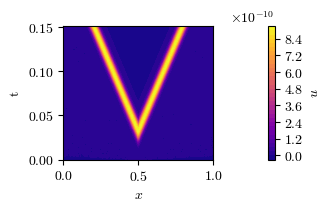

In [6]:
fig, ax = plt.subplots(figsize=(3.2, 2.0))

# Plot the contour graph
contourf_plot = ax.contourf(x_grid_normalized, t_grid_normalized, u_grid, origin='lower', extent=(0, 1, 0, 1), levels=30, cmap='plasma')
ax.set_xlabel('$x$')
ax.set_ylabel('t')
fig.colorbar(contourf_plot, ax=ax, label='$u$')

# Display the plot
plt.show()   

This cell defines a neural network with three fully connected layers, creates an instance of this network, and sets up the Adam optimizer and Mean Squared Error loss function for training the network.

In [7]:
# Define a neural network class with three fully connected layers
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # Define the layers
        self.layer1 = nn.Linear(2, 20)
        self.layer2 = nn.Linear(20, 20)
        self.layer3 = nn.Linear(20, 20)
        self.output_layer = nn.Linear(20, 1)

    def forward(self, x):
        # Define the forward pass
        x = torch.tanh(self.layer1(x))
        x = torch.tanh(self.layer2(x))
        x = torch.tanh(self.layer3(x))
        x = self.output_layer(x)
        return x

# Create an instance of the neural network
neural_net = NeuralNetwork()

# Define the learning rate
learning_rate = 0.01

# Define an optimizer (Adam) for training the network
optimizer = optim.Adam(neural_net.parameters(), lr=learning_rate)

# Define a loss function (Mean Squared Error) for training the network
loss_func = nn.MSELoss()

This cell creates the input data by concatenating normalized `x` and `t` grid tensors, defines the output data, and selects a subset for training. The subset consists of the first third of the `t` coordinate and the entire `x` coordinate, chosen using random indices.

In [8]:
# Concatenate x and t tensors to form the input data
input_data = torch.cat((x_grid_tensor_normalized, t_grid_tensor_normalized), dim=-1)

# Define the output data
output_data = u_grid_tensor_normalized

# Use only a fraction of the input data as the selected indices for training
selected_data = input_data[:int(input_data.shape[0]/3), :][:int(input_data.shape[1]), :]

# Use only a fraction of the output data as the selected indices for training
output_data_2 = output_data[:int(input_data.shape[0]/3), :][:int(input_data.shape[1]), :]

# Define the number of random indices to select
num_indices_1 = int(selected_data.shape[0]/1)
num_indices_2 = int(selected_data.shape[1]/1)


# Select random indices from the first dimension of input_data
indices_1 = random.sample(range(selected_data.shape[0]), num_indices_1)

# Select random indices from the second dimension of input_data
indices_2 = random.sample(range(selected_data.shape[1]), num_indices_2)

# Use only the selected indices for training
selected_data = selected_data[indices_1, :][:, indices_2]

# Select the same indices from output_data
output_data_2 = output_data[indices_1, :][:, indices_2]

# Print the shape of the input data
print(selected_data.shape)

torch.Size([66, 200, 2])


In [9]:
# Make a prediction based on the input data
prediction_data = neural_net(selected_data)
data_loss_init = loss_func(prediction_data, output_data_2)
data_loss_init=data_loss_init.detach()

This cell trains the neural network, tracks the loss over iterations, calculates the training time, and writes a summary of the training process to a text file.

In [10]:
# Initialize a list to store the loss values
loss_values = []

# Start the timer
start_time = time.time()

# Define the number of training iterations
num_iterations = 10_001

# Train the neural network
for i in range(num_iterations):
    # Make a prediction based on the input data
    prediction_data = neural_net(selected_data)

    data_loss = loss_func(prediction_data, output_data_2)

    loss = data_loss/data_loss_init

    loss_values.append(loss.item())

    # Print the loss every 1000 iterations
    if i % 1000 == 0:
        print(f"Iteration {i}: Loss {loss.item()}")

    # Clear gradients for the next training iteration
    optimizer.zero_grad()

    # Perform backpropagation and compute gradients
    loss.backward(retain_graph=True)

    # Update the weights
    optimizer.step()

# Stop the timer and calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time} seconds")

# Define the summary file path
summary_file_path = "summaries/5_1D_Wave_Source_PINNs.txt"

# Save a summary of the training process to a text file
with open(summary_file_path, "w") as file:
    file.write(f"""
    Summary of Neural Network Training
    =================================
    
    Neural Network Architecture:
    {neural_net}
    
    Optimizer Used:
    {type(optimizer).__name__}
    
    Learning Rate:
    {optimizer.param_groups[0]['lr']}
    
    Number of Iterations:
    {len(loss_values)}
    
    Initial Loss:
    {loss_values[0]}
    
    Average Loss:
    {sum(loss_values) / len(loss_values)}
    
    Minimum Loss:
    {min(loss_values)} at iteration {loss_values.index(min(loss_values))}
    
    Final Loss:
    {loss_values[-1]}
    
    Training Time:
    {elapsed_time} seconds
    """)

Iteration 0: Loss 1.0
Iteration 1000: Loss 0.010159489698708057


KeyboardInterrupt: 

In [671]:
# Save the trained model's parameters to a file
torch.save(neural_net.state_dict(), 'models/5_1D_Wave_Source_PINNs.pth')

# Initialize a new instance of the neural network
neural_net = NeuralNetwork()

# Load the saved parameters into the new instance of the neural network
neural_net.load_state_dict(torch.load('models/5_1D_Wave_Source_PINNs.pth'))

# Ensure the new neural network is in evaluation mode
neural_net.eval()

NeuralNetwork(
  (layer1): Linear(in_features=2, out_features=20, bias=True)
  (layer2): Linear(in_features=20, out_features=20, bias=True)
  (layer3): Linear(in_features=20, out_features=20, bias=True)
  (output_layer): Linear(in_features=20, out_features=1, bias=True)
)

This cell concatenates normalized x and t grid tensors to form the input data, generates predictions using the trained neural network, rescales the predictions, and then plots the original, predicted, and difference between predicted and original values in a contour graph.

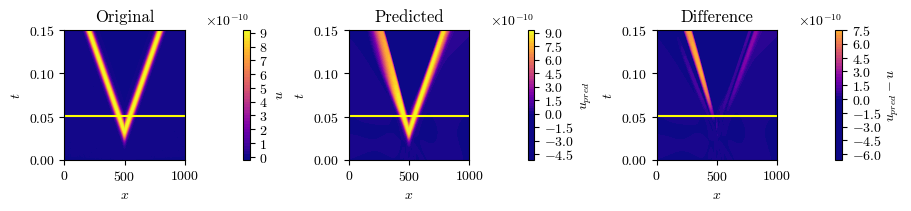

In [672]:
# Concatenation of x and y to form the input data
input_data = torch.cat((x_grid_tensor_normalized, t_grid_tensor_normalized), dim=-1)

# Generate predictions using the neural network and reshape to match grid
u_pred = neural_net(input_data).detach().numpy().reshape(x_grid_normalized.shape)

# Rescale u_pred
u_pred = u_pred * (np.max(u_grid) - np.min(u_grid)) + np.min(u_grid)

# Define a function to plot a contour graph
def plot_contour(ax, x, y, z, title, label):
    im = ax.contourf(x, y, z, origin='lower', levels=50, cmap='plasma', vmax=np.max(u_grid), vmin=np.min(u_grid))#
    ax.set_title(title)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$t$')
    fig.colorbar(im, ax=ax, label=label)
    # Draw a horizontal line at t=np.max(t_grid)/2
    ax.axhline(y=np.max(t_grid)/3, color='yellow')
    
    

# Create a figure with two subplots
fig, axs = plt.subplots(1, 3, figsize=(9, 2))

# Plot the original u values
plot_contour(axs[0], x_grid, t_grid, u_grid, 'Original', '$u$')

# Plot the predicted u values
plot_contour(axs[1], x_grid, t_grid, u_pred, 'Predicted', '$u_{pred}$')

# Plot the difference between the predicted and analytical u values
plot_contour(axs[2], x_grid, t_grid, u_pred-u_grid, 'Difference', '$u_{pred}-u$')

# Uncomment the following line to save the plot as a PNG file in the 'imgs' directory
fig.savefig('imgs/5_Predicted_and_Difference_1D_Wave_Source_PINNs.png', format='png')

# Display the plot
plt.show()

This cell creates a figure with three subplots, defines functions for plotting a contour graph and a line graph, uses these functions to plot the contour graph and two line graphs at different time steps, and finally displays the plot.

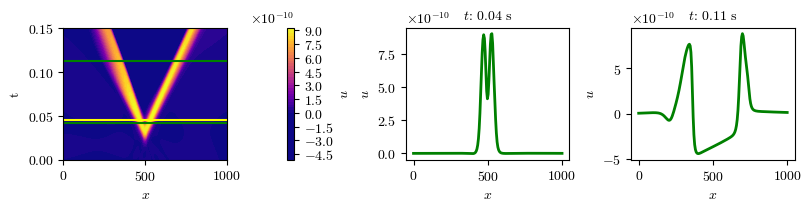

In [673]:
# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(8.0, 2.0))

# Define the fractions for the horizontal lines and line graphs
fractions = [0.28, 0.75]

# Define a function to plot a contour graph
def plot_contour(ax, x, y, z, fractions):
    contourf_plot = ax.contourf(x, y, z, origin='lower', extent=(0, 1, 0, 1), levels=50, cmap='plasma', vmax=np.max(u_grid), vmin=np.min(u_grid))
    ax.set_xlabel('$x$')
    ax.set_ylabel('t')
    fig.colorbar(contourf_plot, ax=ax, label='$u$')
    # Draw a horizontal line at t=np.max(t_grid)/2
    ax.axhline(y=np.max(t_grid)*0.3, color='yellow')
    for fraction in fractions:
        ax.axhline(np.max(y)*fraction, color='green')

# Define a function to plot a line graph
def plot_line(ax, x, y, t):
    ax.plot(x, y, color='green', linewidth=2)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u$')
    ax.set_title("$t$: {:.2f} s".format(t), fontsize=10)

# Plot the contour graph
plot_contour(axs[0], x_grid, t_grid, u_pred, fractions)

# Plot the line graphs
for i, fraction in enumerate(fractions, start=1):
    plot_line(axs[i], x_grid[int(x_grid.shape[0]*fraction),:], u_pred[int(x_grid.shape[0]*fraction),:], t_grid[int(x_grid.shape[0]*fraction),0])


fig.savefig('imgs/5_1D_Wave_Source_PINNs.png', format='png')
# Display the plot
plt.show()

In [686]:
# Define a neural network class with three fully connected layers
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # Define the layers
        self.layer1 = nn.Linear(2, 20)
        self.layer2 = nn.Linear(20, 20)
        self.layer3 = nn.Linear(20, 20)
        self.output_layer = nn.Linear(20, 1)

    def forward(self, x):
        # Define the forward pass
        x = torch.tanh(self.layer1(x))
        x = torch.tanh(self.layer2(x))
        x = torch.tanh(self.layer3(x))
        x = self.output_layer(x)
        return x

# Create an instance of the neural network
neural_net_2 = NeuralNetwork()

# Define the learning rate
learning_rate = 0.01

# Define an optimizer (Adam) for training the network
optimizer = optim.Adam(neural_net_2.parameters(), lr=learning_rate)

# Define a loss function (Mean Squared Error) for training the network
loss_func = nn.MSELoss()

In [687]:
# Concatenate x and t tensors to form the input data
input_data = torch.cat((x_grid_tensor_normalized, t_grid_tensor_normalized), dim=-1)

# Define the output data
output_data = u_grid_tensor_normalized

# Use only a fraction of the input data as the selected indices for training
selected_data = input_data[:int(input_data.shape[0]/3), :][:int(input_data.shape[1]), :]

# Use only a fraction of the output data as the selected indices for training
output_data_2 = output_data[:int(input_data.shape[0]/3), :][:int(input_data.shape[1]), :]

# Define the number of random indices to select
num_indices_1 = int(selected_data.shape[0]/1)
num_indices_2 = int(selected_data.shape[1]/1)


# Select random indices from the first dimension of input_data
indices_1 = random.sample(range(selected_data.shape[0]), num_indices_1)

# Select random indices from the second dimension of input_data
indices_2 = random.sample(range(selected_data.shape[1]), num_indices_2)

# Use only the selected indices for training
selected_data = selected_data[indices_1, :][:, indices_2]

# Select the same indices from output_data
output_data_2 = output_data[indices_1, :][:, indices_2]

# Print the shape of the input data
print(selected_data.shape)

torch.Size([66, 200, 2])


In [688]:
prediction_data = neural_net_2(selected_data)
#prediction_data = prediction_data * (u_grid_tensor.max() - u_grid_tensor.min()) + u_grid_tensor.min()
#prediction_data = (prediction_data - u_grid_tensor.min()) / (u_grid_tensor.max() - u_grid_tensor.min())
#u_grid_tensor_normalized = (u_grid_tensor - u_grid_tensor.min()) / (u_grid_tensor.max() - u_grid_tensor.min())
data_loss = loss_func(prediction_data, output_data_2)
#data_loss = data_loss#*1e+10
# Predictions for physics conditions
prediction_physics_loss = neural_net_2(input_data)
#prediction_physics_loss = prediction_physics_loss * (torch.max(u_grid_tensor) - torch.min(u_grid_tensor)) + torch.min(u_grid_tensor)

# Compute derivatives of prediction with respect to x and t
dudx  = mu*torch.autograd.grad(prediction_physics_loss, x_grid_tensor_normalized, torch.ones_like(prediction_physics_loss), create_graph=True)[0] # computes du/dx
dudx2 = torch.autograd.grad(dudx,  x_grid_tensor_normalized, torch.ones_like(dudx),  create_graph=True)[0] # computes d^2u/dx^2
dudt  = torch.autograd.grad(prediction_physics_loss, t_grid_tensor_normalized, torch.ones_like(prediction_physics_loss), create_graph=True)[0] # computes du/dt
dudt2 = torch.autograd.grad(dudt,  t_grid_tensor_normalized, torch.ones_like(dudt),  create_graph=True)[0] # computes d^2u/dt^2

# Compute physics condition
physics =  rho*dudt2 - dudx2 - source_grid_tensor 

# Compute loss for physics condition
physics_loss = torch.mean(physics**2)

# Calculate the loss
# Total loss is the sum of boundary and physics loss
loss = data_loss + physics_loss
physics_loss_init=physics_loss.detach()
data_loss_init=data_loss.detach()
print(data_loss_init)
print(physics_loss_init)

tensor(0.1036)
tensor(4.3755e+23)


In [689]:
# Initialize a list to store the loss values
loss_values = []

# Start the timer
start_time = time.time()

# Define the number of training iterations
num_iterations = 10_001

# Train the neural network
for i in range(num_iterations):


    # Make a prediction based on the input data
    prediction_data = neural_net_2(selected_data)
    data_loss = loss_func(prediction_data, output_data_2)
    data_loss = data_loss/data_loss_init
    
    # Predictions for physics conditions
    prediction_physics_loss = neural_net_2(input_data)

    # Compute derivatives of prediction with respect to x and t
    dudx  = mu*torch.autograd.grad(prediction_physics_loss, x_grid_tensor_normalized, torch.ones_like(prediction_physics_loss), create_graph=True)[0] # computes du/dx
    dudx2 = torch.autograd.grad(dudx,  x_grid_tensor_normalized, torch.ones_like(dudx),  create_graph=True)[0] # computes d^2u/dx^2
    dudt  = torch.autograd.grad(prediction_physics_loss, t_grid_tensor_normalized, torch.ones_like(prediction_physics_loss), create_graph=True)[0] # computes du/dt
    dudt2 = torch.autograd.grad(dudt,  t_grid_tensor_normalized, torch.ones_like(dudt),  create_graph=True)[0] # computes d^2u/dt^2

    # Compute physics condition
    physics =  rho*dudt2 - dudx2 - source_grid_tensor 

    # Compute loss for physics condition
    physics_loss = torch.mean(physics**2)
    physics_loss = physics_loss/physics_loss_init 
    
    # Calculate the loss
    # Total loss is the sum of boundary and physics loss
    loss = data_loss + physics_loss
    
    # Append the current loss value to the list    
    loss_values.append(loss.item())
    
    # Print the loss every 1000 iterations
    if i % 100 == 0:
        print(f"Iteration {i}: Loss {loss.item()}")
    
    # Clear gradients for the next training iteration
    optimizer.zero_grad()
    
    # Perform backpropagation and compute gradients
    loss.backward(retain_graph=True)
    
    # Update the weights
    optimizer.step()
  
# Stop the timer and calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time} seconds")

# Define the summary file path
summary_file_path = "summaries/5_2_1D_Wave_Source_PINNs.txt"

# Save a summary of the training process to a text file
with open(summary_file_path, "w") as file:
    file.write("Summary of Neural Network Training\n")
    file.write("=================================\n\n")
    file.write(f"Neural Network Architecture:\n{neural_net}\n\n")
    file.write(f"Optimizer Used:\n{type(optimizer).__name__}\n\n")
    file.write(f"Learning Rate:\n{optimizer.param_groups[0]['lr']}\n\n")
    file.write(f"Number of Iterations:\n{len(loss_values)}\n\n")
    file.write(f"Initial Loss:\n{loss_values[0]}\n\n")
    # Calculate the average loss
    average_loss = sum(loss_values) / len(loss_values)
    file.write(f"Average Loss:\n{average_loss}\n\n")
    # Find the iteration with the minimum loss
    min_loss_value = min(loss_values)
    min_loss_iteration = loss_values.index(min_loss_value)
    file.write(f"Minimum Loss:\n{min_loss_value} at iteration {min_loss_iteration}\n\n")    
    file.write(f"Final Loss:\n{loss_values[-1]}\n\n")
    file.write(f"Training Time:\n{elapsed_time} seconds\n\n")    

Iteration 0: Loss 2.0
Iteration 100: Loss 0.2016914039850235
Iteration 200: Loss 0.20129697024822235
Iteration 300: Loss 0.20067445933818817
Iteration 400: Loss 0.19965745508670807
Iteration 500: Loss 0.19789645075798035
Iteration 600: Loss 0.19689102470874786
Iteration 700: Loss 0.20155254006385803
Iteration 800: Loss 0.19652503728866577
Iteration 900: Loss 0.19246520102024078
Iteration 1000: Loss 0.20061209797859192
Iteration 1100: Loss 0.19842953979969025
Iteration 1200: Loss 0.1958075761795044
Iteration 1300: Loss 0.19254593551158905
Iteration 1400: Loss 0.2007085531949997
Iteration 1500: Loss 0.1984821856021881
Iteration 1600: Loss 0.19470132887363434
Iteration 1700: Loss 0.20117749273777008
Iteration 1800: Loss 0.20034752786159515
Iteration 1900: Loss 0.1981964260339737
Iteration 2000: Loss 0.19420382380485535
Iteration 2100: Loss 0.199733167886734
Iteration 2200: Loss 0.1968953013420105
Iteration 2300: Loss 0.1925761103630066
Iteration 2400: Loss 0.2012094259262085


KeyboardInterrupt: 

In [683]:
# Save the trained model's parameters to a file
torch.save(neural_net_2.state_dict(), 'models/5_2_1D_Wave_Source_PINNs.pth')

# Initialize a new instance of the neural network
neural_net_2 = NeuralNetwork()

# Load the saved parameters into the new instance of the neural network
neural_net_2.load_state_dict(torch.load('models/5_2_1D_Wave_Source_PINNs.pth'))

# Ensure the new neural network is in evaluation mode
neural_net_2.eval()

NeuralNetwork(
  (layer1): Linear(in_features=2, out_features=20, bias=True)
  (layer2): Linear(in_features=20, out_features=20, bias=True)
  (layer3): Linear(in_features=20, out_features=20, bias=True)
  (output_layer): Linear(in_features=20, out_features=1, bias=True)
)

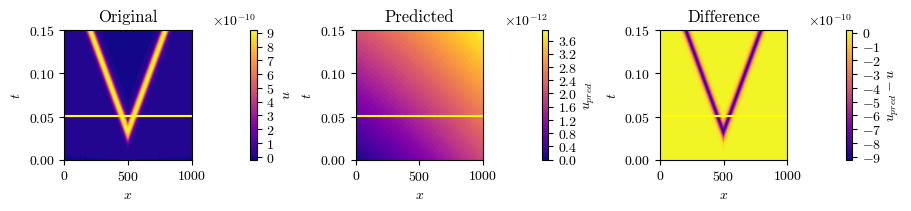

In [684]:
# Concatenation of x and y to form the input data
input_data = torch.cat((x_grid_tensor_normalized, t_grid_tensor_normalized), dim=-1)

# Generate predictions using the neural network and reshape to match grid
u_pred = neural_net_2(input_data).detach().numpy().reshape(x_grid_normalized.shape)

# Rescale u_pred
u_pred = u_pred * (np.max(u_grid) - np.min(u_grid)) + np.min(u_grid)

# Define a function to plot a contour graph
def plot_contour(ax, x, y, z, title, label):
    im = ax.contourf(x, y, z, origin='lower', levels=50, cmap='plasma')#, vmax=np.max(u_grid), vmin=np.min(u_grid)
    ax.set_title(title)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$t$')
    fig.colorbar(im, ax=ax, label=label)
    # Draw a horizontal line at t=np.max(t_grid)/2
    ax.axhline(y=np.max(t_grid)/3, color='yellow')
    
    

# Create a figure with two subplots
fig, axs = plt.subplots(1, 3, figsize=(9, 2))

# Plot the original u values
plot_contour(axs[0], x_grid, t_grid, u_grid, 'Original', '$u$')

# Plot the predicted u values
plot_contour(axs[1], x_grid, t_grid, u_pred, 'Predicted', '$u_{pred}$')

# Plot the difference between the predicted and analytical u values
plot_contour(axs[2], x_grid, t_grid, u_pred-u_grid, 'Difference', '$u_{pred}-u$')

# Uncomment the following line to save the plot as a PNG file in the 'imgs' directory
fig.savefig('imgs/5_2_Predicted_and_Difference_1D_Wave_Source_PINNs.png', format='png')

# Display the plot
plt.show()

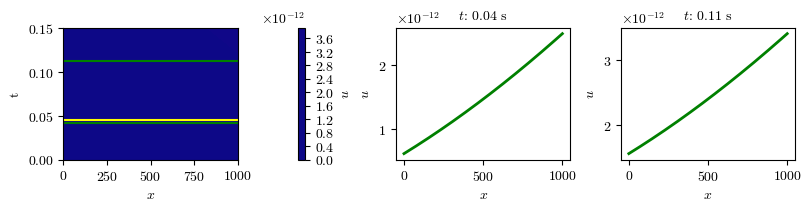

In [685]:
# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(8.0, 2.0))

# Define the fractions for the horizontal lines and line graphs
fractions = [0.28, 0.75]

# Define a function to plot a contour graph
def plot_contour(ax, x, y, z, fractions):
    contourf_plot = ax.contourf(x, y, z, origin='lower', extent=(0, 1, 0, 1), levels=50, cmap='plasma', vmax=np.max(u_grid), vmin=np.min(u_grid))
    ax.set_xlabel('$x$')
    ax.set_ylabel('t')
    fig.colorbar(contourf_plot, ax=ax, label='$u$')
    # Draw a horizontal line at t=np.max(t_grid)/2
    ax.axhline(y=np.max(t_grid)*0.3, color='yellow')
    for fraction in fractions:
        ax.axhline(np.max(y)*fraction, color='green')

# Define a function to plot a line graph
def plot_line(ax, x, y, t):
    ax.plot(x, y, color='green', linewidth=2)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u$')
    ax.set_title("$t$: {:.2f} s".format(t), fontsize=10)

# Plot the contour graph
plot_contour(axs[0], x_grid, t_grid, u_pred, fractions)

# Plot the line graphs
for i, fraction in enumerate(fractions, start=1):
    plot_line(axs[i], x_grid[int(x_grid.shape[0]*fraction),:], u_pred[int(x_grid.shape[0]*fraction),:], t_grid[int(x_grid.shape[0]*fraction),0])


fig.savefig('imgs/5_1D_Wave_Source_PINNs.png', format='png')
# Display the plot
plt.show()